# Executive Summary

This notebook will attempt to answer the following research question:

    What's money got to do with it?

## PLANNING

- [X] Planning
    - [X] import libraries/packages
    - [X] configure notebook environment
    - [X] define helper functions
- [X] Acquire data
    - [X] get PEIMS financial data
    - [X] get STAAR performance data
- [X] Prepare the data
    - [X] prepare PEIMS data
        - [X] get rid of unwanted columns
        - [x] get rid of NaNs
    - [X] prepare STAAR data
        - [X] get rid of duplicates
        - [X] get rid of unwanted columns
        - [X] get rid of NaNs
        - [X] create new columns
        - [X] merge two datasets together
- [ ] Explore the data
    - [ ] examine for multicollinearity and determine truly independent variables
    - [ ] get to know the master dataset
    - [ ] feature engineering
- [ ] Modeling
    - [ ] create, fit, use XGBoost
    - [ ] gridsearch
    - [ ] retrain model using best hyperparameters
    - [ ] extract feature importances

In [1]:
# for manipulating dataframes
import pandas as pd
import numpy as np

# For hypothesis testing
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

ALPHA = 0.05
mannwhitneyu_same = []
mannwhitneyu_diff = []

In [2]:
def get_values(df, columns):
    """
    Take a dataframe and a list of columns and
    returns the value counts for the columns.
    """
    for column in columns:
        print(column)
        print('=====================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param)

In [3]:
def viz_correlation(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    
    # Use the default Pearson for continuous variables
    corr_matrix = dfx.corr(method ='pearson')

    # Setup
    fig, ax = plt.subplots(figsize=(16,8))

    # vmin and vmax control the range of the colormap
    sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f',
               vmin=-1, vmax=1)

    plt.title(graph_title)

    # Add tight_layout to ensure the labels don't get cut off
    plt.tight_layout()
    plt.show()

In [4]:
def viz_scatter(df, graph_title, col1, col2):
    plt.figure(figsize=(16, 8))
    plt.scatter(df[col1], df[col2], alpha=0.5)
    plt.xlabel(col1) #x label
    plt.ylabel(col2) #y label
    plt.title(graph_title)
    plt.show()

In [5]:
def viz_pairplot(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    plt.figure(figsize=(16, 8))
    sns.pairplot(dfx)
    plt.title(graph_title)
    plt.show()

In [6]:
def loop_levene(df1, df2):
    for column in df1.columns:
        result = stats.levene(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - HOMOGENOUS'
        else:
            interpretation = 'significant - HETEROGENOUS'
        print(result, '-', column, ' - ', interpretation)

In [7]:
def loop_shapiro(df):
    for column in df.columns:
        statistic, result = shapiro(df[column])
        if result > ALPHA:
            interpretation = 'insignificant - NORMAL'
        else:
            interpretation = 'significant - ABNORMAL'
        print(result, '-', column, ' - ', interpretation)

In [8]:
def loop_ttest(df1, df2):
    for column in df1.columns:
        result = stats.ttest_ind(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - SAME'
        else:
            interpretation = 'significant - DIFFERENT'
        print(result, '-', column, ' - ', interpretation)

In [9]:
def loop_mannwhitney(df1, df2):

    for column in df1.columns:
        stat, p = mannwhitneyu(df1[column], df2[column])

        if p > ALPHA:
            interpretation = 'SAME (fail to reject H0)'
            print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
            mannwhitneyu_same.append(column)
        else:
            interpretation = 'DIFFERENT (reject H0)'
            print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
            mannwhitneyu_diff.append(column)

In [10]:
def viz_boxplot(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.boxplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

In [11]:
def viz_violin(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.violinplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

## ACQUIRE DATA

In [12]:
# Get the PEIMS and STAAR datasets
staar = pd.read_csv('../data/inter/clean_staar_2019.csv')
peims = pd.read_csv('../data/inter/clean_peims_2019.csv')

In [13]:
staar.head()
peims.head()

,District,Proficiency,Rate
0,1902,approaches,84.55
1,1902,masters,28.86
2,1902,meets,61.48
3,1903,approaches,83.93
4,1903,masters,26.52


,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,1902,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,1903,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
2,1904,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,0,0,0,0,571388,2445660,481
3,1906,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,0,22400,0,0,1412589,53786
4,1907,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,0,0,52678,0,1214433,10940857,0


## PREPARATION

In [14]:
staar = staar.astype({"District": str})
peims = peims.astype({"District": str})

In [15]:
# Padd District numbers with 0's
staar['District'] = staar['District'].str.zfill(6)
peims['District'] = peims['District'].str.zfill(6)

In [16]:
# Separate by proficiency column
staar_approaches =  staar.loc[staar['Proficiency'] == 'approaches']
staar_meets =  staar.loc[staar['Proficiency'] == 'meets']
staar_masters =  staar.loc[staar['Proficiency'] == 'masters']

In [17]:
df_approaches = pd.merge(staar_approaches, peims, on=['District'])
df_meets = pd.merge(staar_meets, peims, on=['District'])
df_masters = pd.merge(staar_masters, peims, on=['District'])

In [18]:
df_approaches.head()
df_meets.head()
df_masters.head()

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001903,approaches,83.93,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
2,001904,approaches,81.25,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,0,0,0,0,571388,2445660,481
3,001906,approaches,86.47,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,0,22400,0,0,1412589,53786
4,001907,approaches,71.86,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,0,0,52678,0,1214433,10940857,0


,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,meets,61.48,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001903,meets,56.40,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
2,001904,meets,53.33,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,0,0,0,0,571388,2445660,481
3,001906,meets,52.02,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,0,22400,0,0,1412589,53786
4,001907,meets,41.75,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,0,0,52678,0,1214433,10940857,0


,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,masters,28.86,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001903,masters,26.52,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
2,001904,masters,24.62,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,0,0,0,0,571388,2445660,481
3,001906,masters,21.79,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,0,22400,0,0,1412589,53786
4,001907,masters,17.81,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,0,0,52678,0,1214433,10940857,0


In [19]:
df_approaches.to_csv('../data/inter/clean_approaches_2019.csv', index=False)
df_meets.to_csv('../data/inter/clean_meets_2019.csv', index=False)
df_masters.to_csv('../data/inter/clean_masters_2019.csv', index=False)

## EXPLORATION

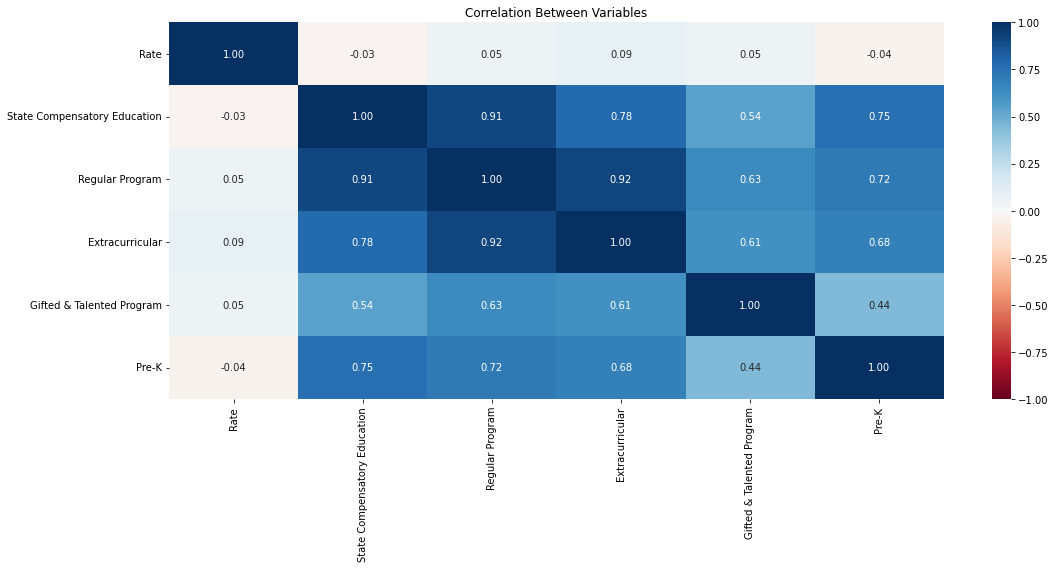

In [20]:
viz_correlation(df_approaches, 'Correlation Between Variables',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

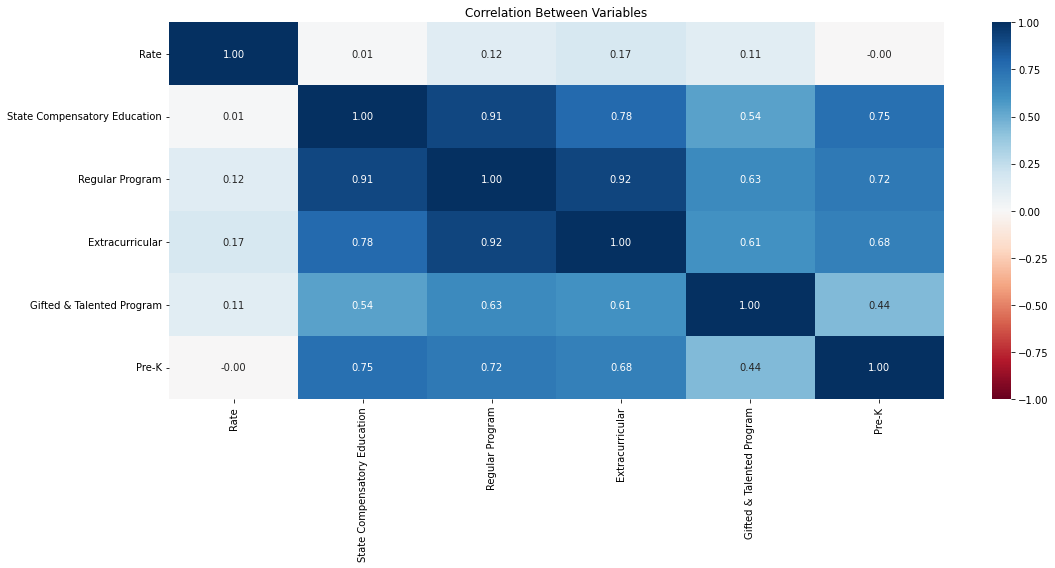

In [21]:
viz_correlation(df_meets, 'Correlation Between Variables',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

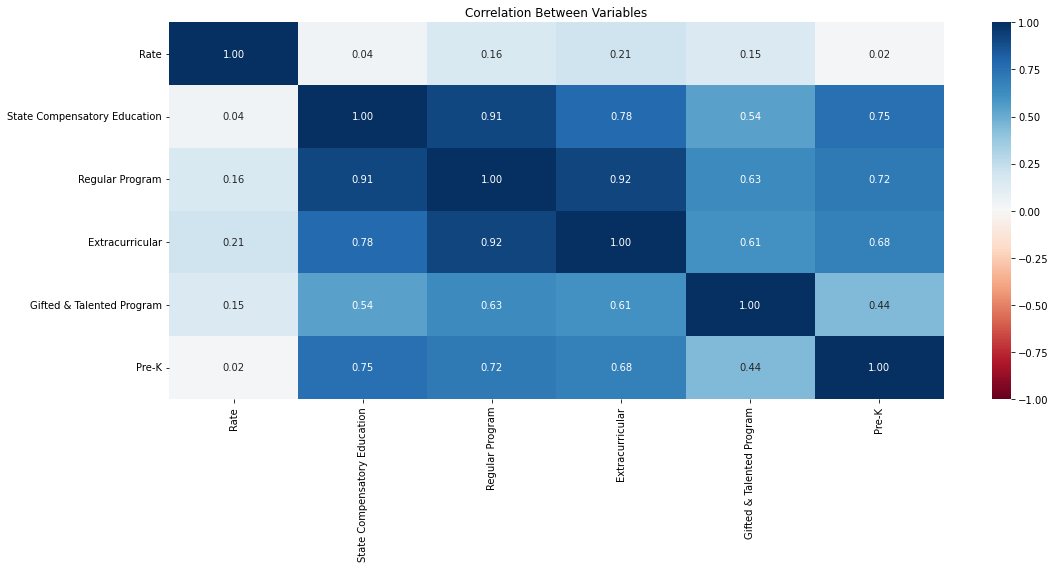

In [22]:
viz_correlation(df_masters, 'Correlation Between Variables',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

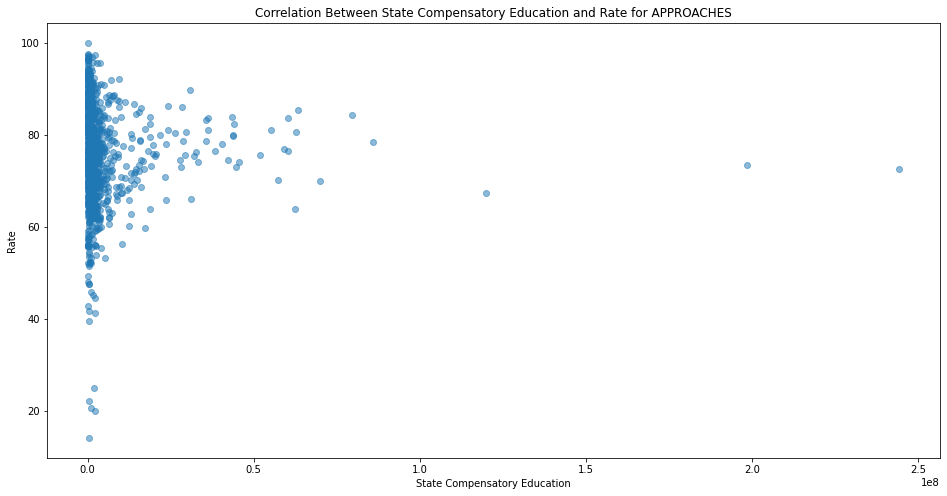

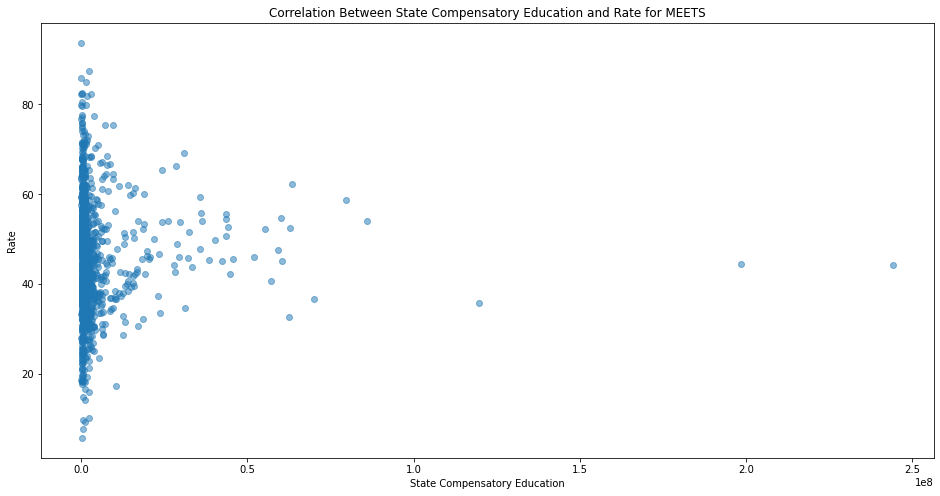

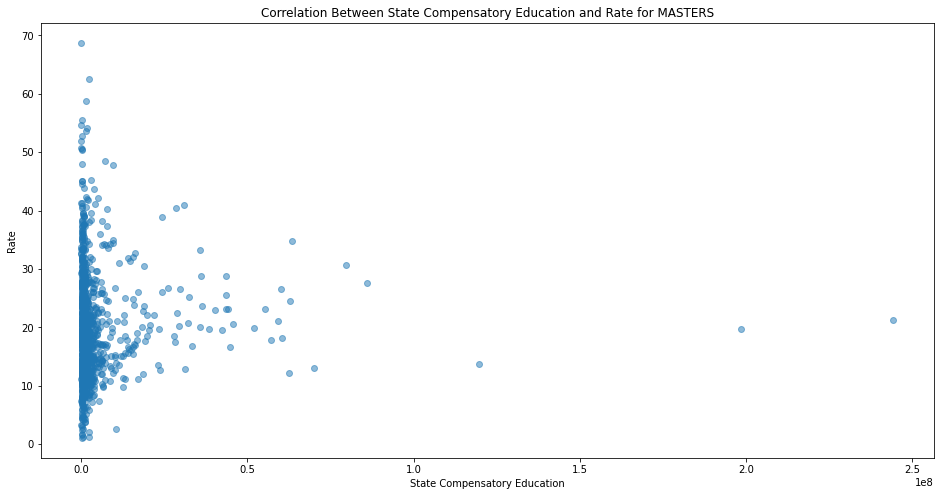

In [23]:
viz_scatter(df_approaches, 'Correlation Between State Compensatory Education and Rate for APPROACHES', 'State Compensatory Education', 'Rate')
viz_scatter(df_meets, 'Correlation Between State Compensatory Education and Rate for MEETS', 'State Compensatory Education', 'Rate')
viz_scatter(df_masters, 'Correlation Between State Compensatory Education and Rate for MASTERS', 'State Compensatory Education', 'Rate')

<Figure size 1152x576 with 0 Axes>

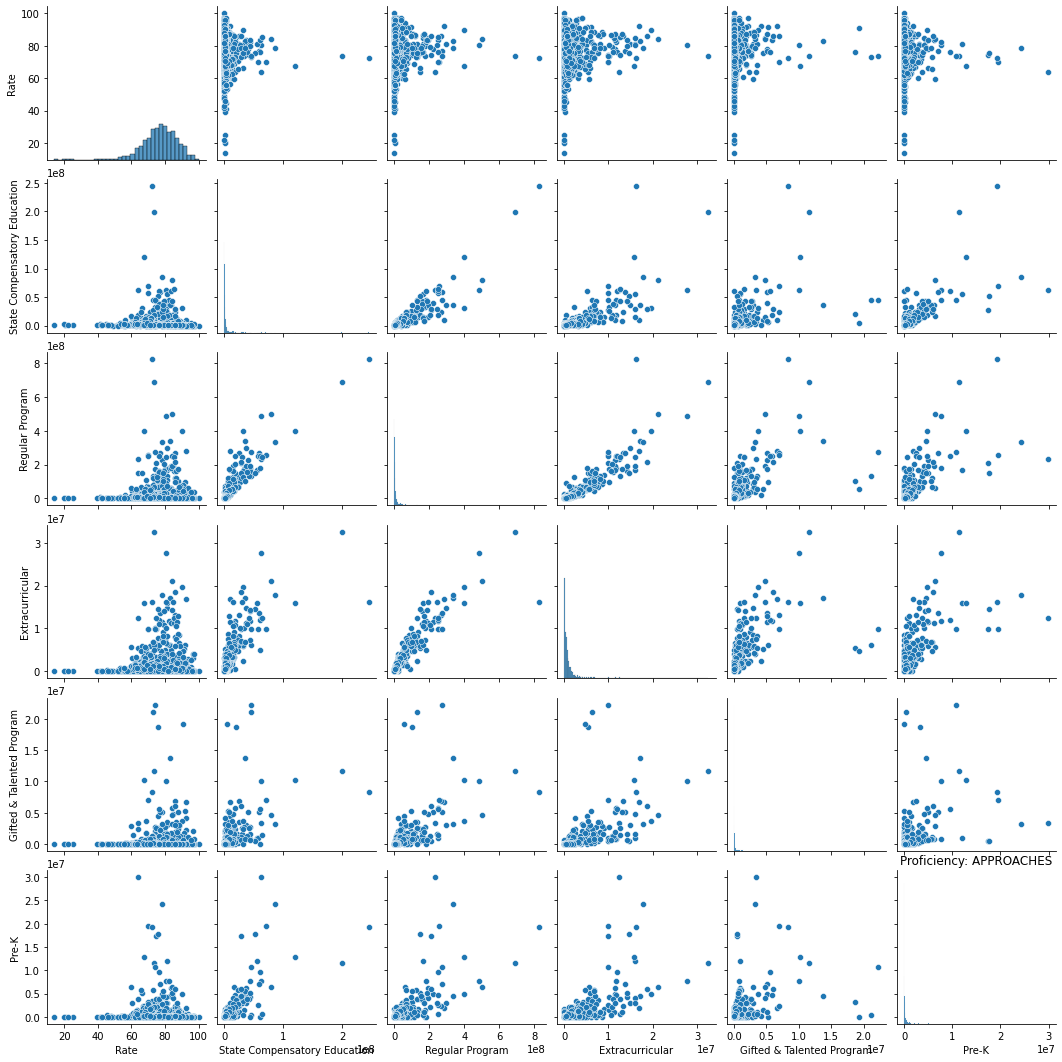

<Figure size 1152x576 with 0 Axes>

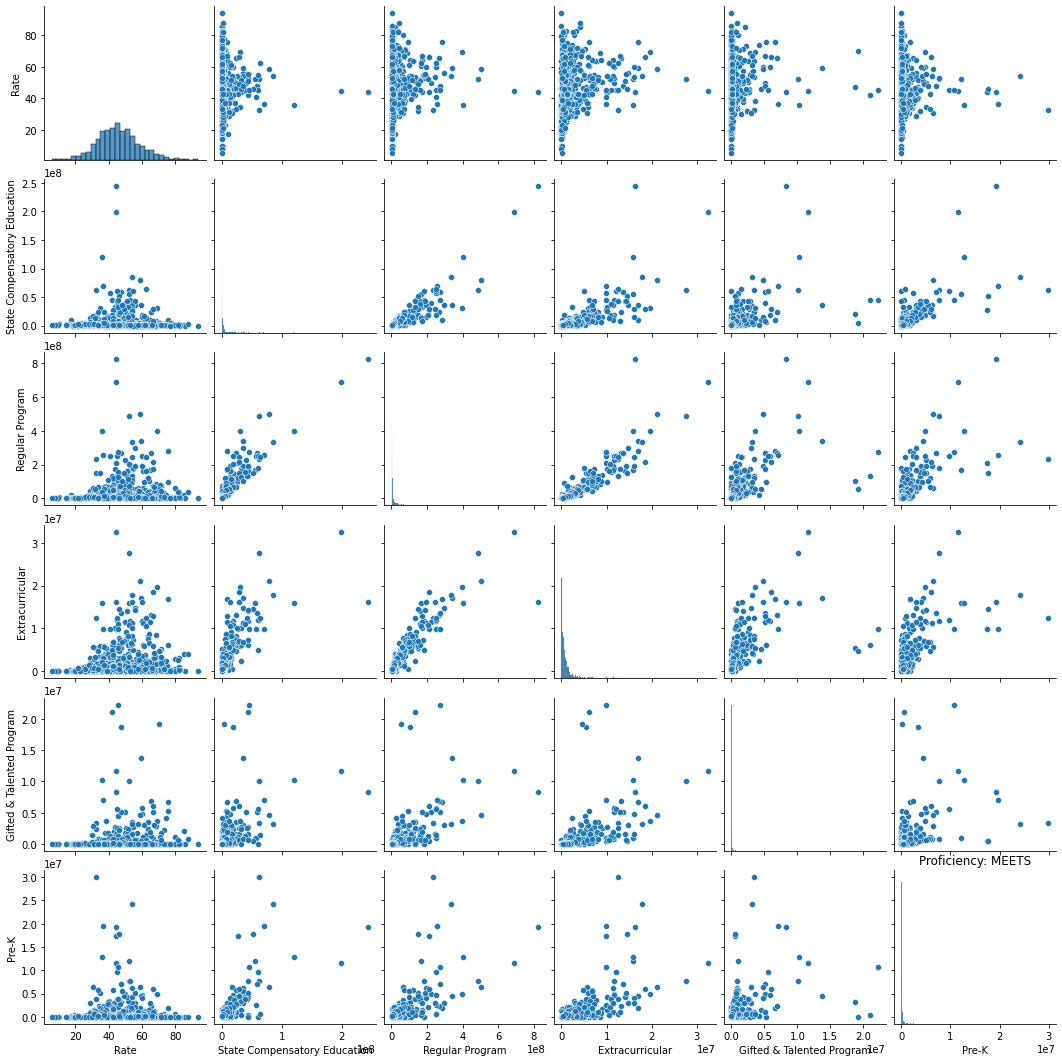

<Figure size 1152x576 with 0 Axes>

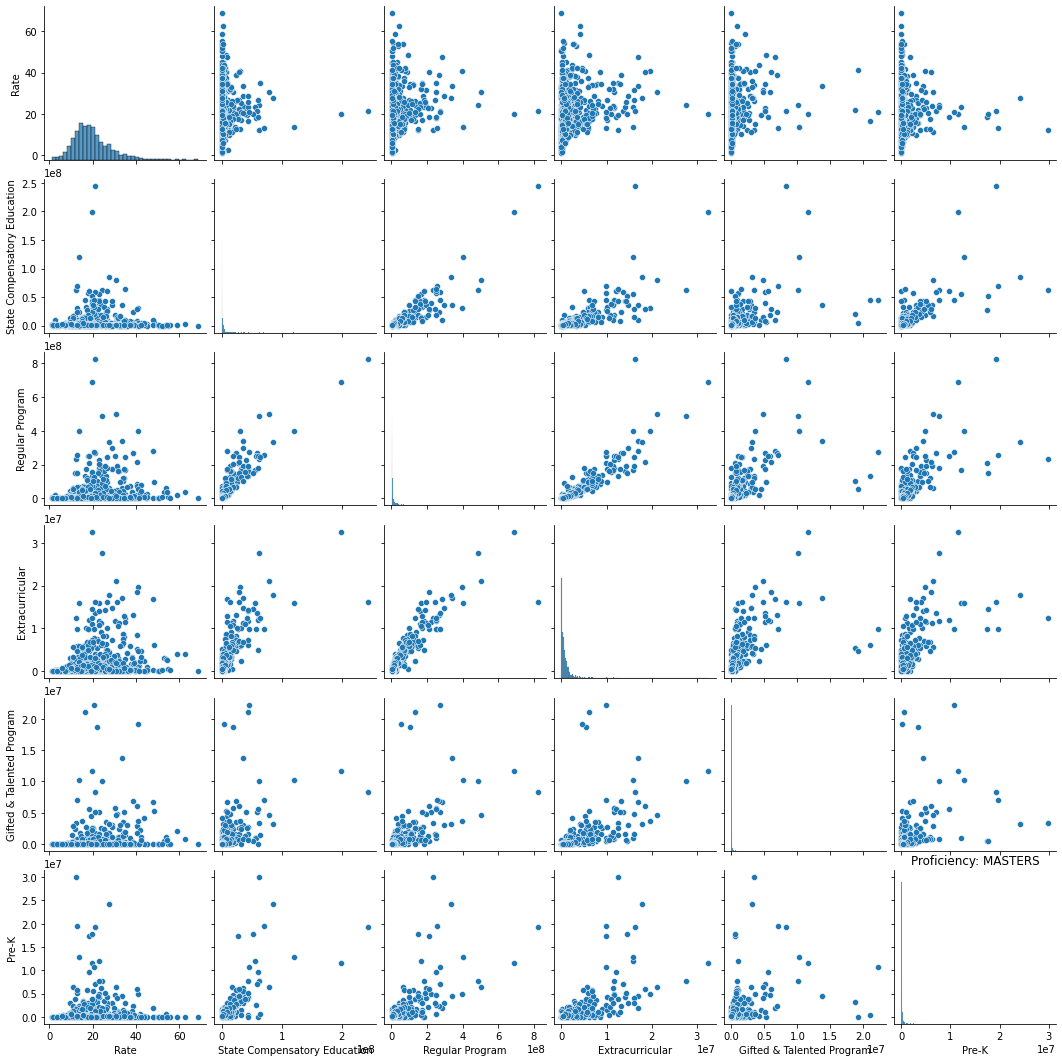

In [24]:
viz_pairplot(df_approaches, 'Proficiency: APPROACHES',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

viz_pairplot(df_meets, 'Proficiency: MEETS',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

viz_pairplot(df_masters, 'Proficiency: MASTERS',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

In [25]:
df_approaches.head(2)
df_meets.head(2)
df_masters.head(2)

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001903,approaches,83.93,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465


,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,meets,61.48,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001903,meets,56.40,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465


,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,masters,28.86,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001903,masters,26.52,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465


In [26]:
dfx_approaches = df_approaches.drop(columns=['District', 'Proficiency'])
dfx_meets = df_meets.drop(columns=['District', 'Proficiency'])
dfx_masters = df_masters.drop(columns=['District', 'Proficiency'])

In [27]:
approaches = dfx_approaches.copy()
meets = dfx_meets.copy()
masters = dfx_masters.copy()

In [28]:
loop_levene(approaches, masters)

6.523371300571383e-07 - Rate  -  significant - HETEROGENOUS
0.9898489521234958 - Payroll  -  insignificant - HOMOGENOUS
0.9913530654090241 - Professional & Contracted  -  insignificant - HOMOGENOUS
0.9907725710610892 - Supplies & Materials  -  insignificant - HOMOGENOUS
0.9907555753573823 - Other Operating  -  insignificant - HOMOGENOUS
0.9898108357382772 - Instruction & Transfer  -  insignificant - HOMOGENOUS
0.9906357307707038 - Instructional Resource Media  -  insignificant - HOMOGENOUS
0.992486316807114 - Curriculum/Staff Development  -  insignificant - HOMOGENOUS
0.990974314756075 - Instructional Leadership  -  insignificant - HOMOGENOUS
0.9912081442095099 - Campus Administration  -  insignificant - HOMOGENOUS
0.9936282262505446 - Guidance & Counseling  -  insignificant - HOMOGENOUS
0.9940268630767889 - Social Work  -  insignificant - HOMOGENOUS
0.9919898753704267 - Health Services  -  insignificant - HOMOGENOUS
0.9915098859191229 - Transporation  -  insignificant - HOMOGENOUS
0.9

In [29]:
loop_shapiro(approaches)
loop_shapiro(meets)
loop_shapiro(masters)

4.573825920735665e-19 - Rate  -  significant - ABNORMAL
0.0 - Payroll  -  significant - ABNORMAL
0.0 - Professional & Contracted  -  significant - ABNORMAL
0.0 - Supplies & Materials  -  significant - ABNORMAL
0.0 - Other Operating  -  significant - ABNORMAL
0.0 - Instruction & Transfer  -  significant - ABNORMAL
0.0 - Instructional Resource Media  -  significant - ABNORMAL
0.0 - Curriculum/Staff Development  -  significant - ABNORMAL
0.0 - Instructional Leadership  -  significant - ABNORMAL
0.0 - Campus Administration  -  significant - ABNORMAL
0.0 - Guidance & Counseling  -  significant - ABNORMAL
0.0 - Social Work  -  significant - ABNORMAL
0.0 - Health Services  -  significant - ABNORMAL
0.0 - Transporation  -  significant - ABNORMAL
0.0 - Food Service  -  significant - ABNORMAL
0.0 - Extracurricular  -  significant - ABNORMAL
0.0 - General Administration  -  significant - ABNORMAL
0.0 - Plant Maintenance/Operation  -  significant - ABNORMAL
0.0 - Security & Monitoring  -  signific

In [30]:
loop_ttest(approaches, masters)

0.0 - Rate  -  significant - DIFFERENT
0.9908123356165257 - Payroll  -  insignificant - SAME
0.9912792641721626 - Professional & Contracted  -  insignificant - SAME
0.9889868696033497 - Supplies & Materials  -  insignificant - SAME
0.98830221602232 - Other Operating  -  insignificant - SAME
0.9908564922206285 - Instruction & Transfer  -  insignificant - SAME
0.9893233148744749 - Instructional Resource Media  -  insignificant - SAME
0.9930561443043122 - Curriculum/Staff Development  -  insignificant - SAME
0.9922154342462799 - Instructional Leadership  -  insignificant - SAME
0.9926152362771543 - Campus Administration  -  insignificant - SAME
0.9946792705352003 - Guidance & Counseling  -  insignificant - SAME
0.9940268630883708 - Social Work  -  insignificant - SAME
0.9897617948487415 - Health Services  -  insignificant - SAME
0.9891119962903816 - Transporation  -  insignificant - SAME
0.9892595939992721 - Food Service  -  insignificant - SAME
0.9843580054119397 - Extracurricular  -  in

In [31]:
df0 = df_approaches.copy()
df1 = df_meets.copy()
df2 = df_masters.copy()

In [32]:
clean = pd.concat([df0, df1, df2])
clean.head()

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001903,approaches,83.93,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
2,001904,approaches,81.25,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,0,0,0,0,571388,2445660,481
3,001906,approaches,86.47,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,0,22400,0,0,1412589,53786
4,001907,approaches,71.86,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,0,0,52678,0,1214433,10940857,0


In [33]:
clean[clean['District'] == '001902']

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
0,001902,meets,61.48,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
0,001902,masters,28.86,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633


In [34]:
clean = clean.loc[clean['Proficiency'] == 'approaches']

In [35]:
clean['Efficient'] = np.where(clean['Rate'] < 70, 1, 0)

In [36]:
clean[clean['District'] == '001902']

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses,Efficient
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633,0


In [37]:
clean.shape

(1198, 39)

In [38]:
show_values(clean, ['Efficient'])

Efficient
0    937
1    261
Name: Efficient, dtype: int64




In [39]:
clean = clean.drop(columns=['Proficiency', 'Rate'])

In [40]:
clean = clean.drop(columns=['District'])

In [41]:
clean.shape

(1198, 36)

In [42]:
clean.head()

,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transporation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses,Efficient
0,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633,0
1,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465,0
2,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,0,0,0,0,571388,2445660,481,0
3,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,0,22400,0,0,1412589,53786,0
4,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,0,0,52678,0,1214433,10940857,0,0


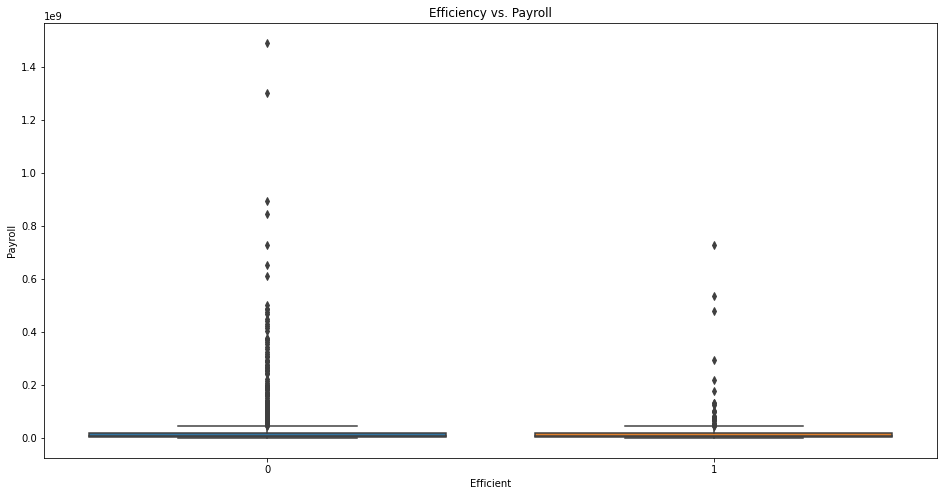

In [43]:
viz_boxplot(clean, 'Efficient', 'Payroll', 'Efficiency vs. Payroll')

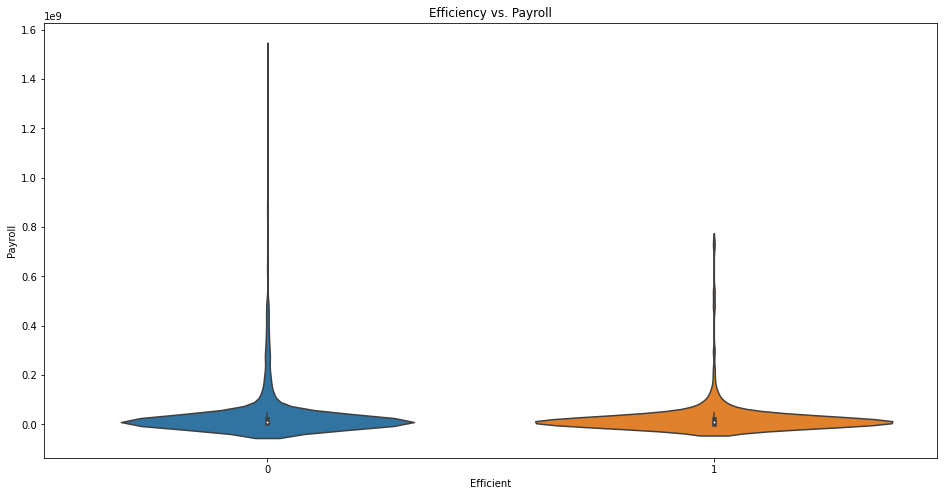

In [44]:
viz_violin(clean, 'Efficient', 'Payroll', 'Efficiency vs. Payroll')

In [45]:
# Separate by Efficient column
clean_0 =  clean.loc[clean['Efficient'] == 0]
clean_1 =  clean.loc[clean['Efficient'] == 1]

In [46]:
loop_levene(clean_0, clean_1)

0.06160948917094894 - Payroll  -  insignificant - HOMOGENOUS
0.3866067094032374 - Professional & Contracted  -  insignificant - HOMOGENOUS
0.16911671139691026 - Supplies & Materials  -  insignificant - HOMOGENOUS
0.028223933686517638 - Other Operating  -  significant - HETEROGENOUS
0.05636852474823748 - Instruction & Transfer  -  insignificant - HOMOGENOUS
0.01500313920715696 - Instructional Resource Media  -  significant - HETEROGENOUS
0.37320594492865755 - Curriculum/Staff Development  -  insignificant - HOMOGENOUS
0.39508862624857877 - Instructional Leadership  -  insignificant - HOMOGENOUS
0.10124708574479288 - Campus Administration  -  insignificant - HOMOGENOUS
0.08013855940469129 - Guidance & Counseling  -  insignificant - HOMOGENOUS
0.9308688686778623 - Social Work  -  insignificant - HOMOGENOUS
0.06277366776073053 - Health Services  -  insignificant - HOMOGENOUS
0.10003218304624857 - Transporation  -  insignificant - HOMOGENOUS
0.2547572904333209 - Food Service  -  insignifica

C:\Users\Dd\OneDrive\Documents\_github\texas-public-schools\v399\lib\site-packages\scipy\stats\_morestats.py:2604: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


In [47]:
loop_shapiro(clean_0)
loop_shapiro(clean_1)

0.0 - Payroll  -  significant - ABNORMAL
0.0 - Professional & Contracted  -  significant - ABNORMAL
0.0 - Supplies & Materials  -  significant - ABNORMAL
0.0 - Other Operating  -  significant - ABNORMAL
0.0 - Instruction & Transfer  -  significant - ABNORMAL
0.0 - Instructional Resource Media  -  significant - ABNORMAL
0.0 - Curriculum/Staff Development  -  significant - ABNORMAL
0.0 - Instructional Leadership  -  significant - ABNORMAL
0.0 - Campus Administration  -  significant - ABNORMAL
0.0 - Guidance & Counseling  -  significant - ABNORMAL
0.0 - Social Work  -  significant - ABNORMAL
0.0 - Health Services  -  significant - ABNORMAL
0.0 - Transporation  -  significant - ABNORMAL
0.0 - Food Service  -  significant - ABNORMAL
0.0 - Extracurricular  -  significant - ABNORMAL
0.0 - General Administration  -  significant - ABNORMAL
0.0 - Plant Maintenance/Operation  -  significant - ABNORMAL
0.0 - Security & Monitoring  -  significant - ABNORMAL
0.0 - Data Processing  -  significant - A

C:\Users\Dd\OneDrive\Documents\_github\texas-public-schools\v399\lib\site-packages\scipy\stats\_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [48]:
loop_mannwhitney(clean_0, clean_1)

Statistics=130634.000, p=0.091 - Payroll - SAME (fail to reject H0)
Statistics=118544.000, p=0.450 - Professional & Contracted - SAME (fail to reject H0)
Statistics=131128.000, p=0.073 - Supplies & Materials - SAME (fail to reject H0)
Statistics=127554.000, p=0.286 - Other Operating - SAME (fail to reject H0)
Statistics=131114.000, p=0.074 - Instruction & Transfer - SAME (fail to reject H0)
Statistics=143467.500, p=0.000 - Instructional Resource Media - DIFFERENT (reject H0)
Statistics=118940.000, p=0.500 - Curriculum/Staff Development - SAME (fail to reject H0)
Statistics=118929.000, p=0.493 - Instructional Leadership - SAME (fail to reject H0)
Statistics=121158.500, p=0.821 - Campus Administration - SAME (fail to reject H0)
Statistics=125119.500, p=0.566 - Guidance & Counseling - SAME (fail to reject H0)
Statistics=107711.000, p=0.000 - Social Work - DIFFERENT (reject H0)
Statistics=136677.000, p=0.004 - Health Services - DIFFERENT (reject H0)
Statistics=130988.000, p=0.078 - Transpo

In [49]:
mannwhitneyu_same

['Payroll',
 'Professional & Contracted',
 'Supplies & Materials',
 'Other Operating',
 'Instruction & Transfer',
 'Curriculum/Staff Development',
 'Instructional Leadership',
 'Campus Administration',
 'Guidance & Counseling',
 'Transporation',
 'Food Service',
 'General Administration',
 'Plant Maintenance/Operation',
 'Security & Monitoring',
 'Data Processing',
 'Students with Disabilities',
 'Bilingual Program',
 'High School Allotment',
 'Pre-K',
 'Pre-K Comp Ed',
 'Pre-K Special Education',
 'Undistributed Program']

In [50]:
mannwhitneyu_diff

['Instructional Resource Media',
 'Social Work',
 'Health Services',
 'Extracurricular',
 'Community Services',
 'Regular Program',
 'Gifted & Talented Program',
 'Career & Technology Program',
 'State Compensatory Education',
 'Pre-K Bilingual',
 'Pre-K Regular',
 'Athletics Program',
 'Other Uses',
 'Efficient']

In [52]:
clean.to_csv('../data/inter/clean_efficient_2019.csv', index=False)